In [15]:
!pip install wandb
import wandb
# Replace with your actual API key
api_key = "17dab9d1bbdc37c41831799a4b0b50d3e97400c5"
project_name='RWBCS2'
# Login to Weights & Biases
wandb.login(key=api_key)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [16]:
import gym
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)
import base64
import io  # For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import datetime

In [17]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)

In [18]:
env = gym.make('CartPole-v1')
env.seed(0)
state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n
# print('observation space:', env.observation_space)
# print('action space:', env.action_space)


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [19]:

class Policy(nn.Module):
    def __init__(self, state_size=4, action_size=2, hidden_size=32):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        # we just consider 1 dimensional probability of action
        return F.softmax(x, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)


In [20]:

def reinforce(policy, optimizer, n_episodes=2000, max_t=1000, gamma=0.99, print_every=100):
    scores_window = deque(maxlen=100)
    scores = []
    average_scores_epsgrdy = []
    episode_list_epsgrdy = []
    flag = False
    for e in range(1, n_episodes):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        # Collect trajectory
        for t in range(max_t):
            # Sample the action from current policy
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
        # Calculate total expected reward
        scores_window.append(sum(rewards))
        scores.append(sum(rewards))

        average_score = np.mean(scores_window)
        average_scores_epsgrdy.append(average_score)

        wandb.log({'average_score': average_score})

        episode_list_epsgrdy.append(e)


        # Recalculate the total reward applying discounted factor
        discounts = [gamma ** i for i in range(len(rewards) + 1)]
        R = sum([a * b for a,b in zip(discounts, rewards)])

        # Calculate the loss
        policy_loss = []
        for t, log_prob in enumerate(saved_log_probs):
            # Note that we are using Gradient Ascent, not Descent. So we need to calculate it with negative rewards.
            policy_loss.append(-log_prob * R )
        # After that, we concatenate whole policy loss in 0th dimension
        policy_loss = torch.cat(policy_loss).sum()

        # Backpropagation
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if e % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_window)))
        if np.mean(scores_window) >= 195.0 and flag == False:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e - 100, np.mean(scores_window)))
            flag = True
            break
    return episode_list_epsgrdy, average_scores_epsgrdy




In [21]:
wandb.init(project=project_name)

average_score,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▄▆▇▇▇████▇▆▄
average_score,148.88


In [22]:
env = gym.make('CartPole-v1')
env.seed(0)
state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n

In [23]:
sweep_config = {
    'method': 'grid',
    'metric': {
      'name': 'Average Reward',
      'goal': 'maximize'
    },
    'parameters': {
        'state_size': {
            'values': [state_shape]
        },
        'action_size': {
            'values': [action_shape]
        },
        'hidden_size': {
            'values': [64]
        },
        'max_t': {
            'values': [1000]
        },
        'lr': {
            'values': [1e-3]
        },
        'gamma': {
            'values': [0.99]
        },
        'alpha': {
            'values': [0.0001]
        },
        'n_episodes': {
            'values': [2000]
        },
        "max_t":{
            'values': [1000]
        },
         "print_every": {
             'values': [100]
         }
    }
}

In [24]:
# Initialize a new sweep
sweep_id = wandb.sweep(sweep=sweep_config,  project=project_name)


Create sweep with ID: opv2rriv
Sweep URL: https://wandb.ai/iitm_aero/RWBCS2/sweeps/opv2rriv


In [25]:
average_scores = []

In [26]:
def AvgOverExperiments():

    # with wandb.init() as run:
        # Get the hyperparameters for this run
        # config = wandb.config

        # begin_time = datetime.datetime.now()
        config= {
        'state_size': state_shape,
        'action_size':action_shape,
        'hidden_size':64,
        'max_t':1000,
        'lr':1e-3,
        'gamma':0.99,
        'alpha':0.0001,
        'n_episodes':2000,
        "max_t": 1000,
        "print_every": 100
        }
        # config = sweep_config
        begin_time = datetime.datetime.now()
        # Create the policy network with the specified hyperparameters
        policy = Policy(state_size=4, action_size=2, hidden_size=config["hidden_size"])
        optimizer = optim.Adam(policy.parameters(), lr=config["lr"])

        # Run the REINFORCE algorithm with the specified hyperparameters
        episode_list_epsgrdy, average_scores_epsgrdy = reinforce(policy, optimizer, n_episodes=config["n_episodes"], max_t=config["max_t"], gamma=config["gamma"], print_every=config["print_every"])

        time_taken = datetime.datetime.now() - begin_time
        print(time_taken)
        # time_taken = datetime.datetime.now() - begin_time
        print(average_scores_epsgrdy)
        print('\n')
        average_scores.append(average_scores_epsgrdy)
        # print(time_taken)
        # Log the final average score to wandb
        # wandb.log({"Average Score": average_scores_epsgrdy})
        # wandb.log({"Average Score": cumulative_regret})


In [27]:
def plot_avg_curves(avg_reward,reward_std, step_size = 1 ):

    trunc_avg_reward = avg_reward[0::step_size]
    tunc_reward_std = reward_std[0::step_size]

    # trunc_avg_step = avg_step[0::step_size]
    # tunc_step_std = step_std[0::step_size]

    # Plot the average rewards with mean and standard deviation
    plt.figure()
    plt.plot(trunc_avg_reward, label='Mean')
    plt.fill_between(range(step_size), trunc_avg_reward + tunc_reward_std, trunc_avg_reward - tunc_reward_std, alpha=0.5, label=' Std Dev')
    plt.xlabel('Episode')
    plt.ylabel('Average Total Reward')
    plt.title('Average Total Reward vs Episode')
    plt.legend()
    # plt.savefig( "RvsE " +".pdf")
    # files.download(exp_no+"_RvsE.png")
    plt.show()



    # # Plot the average rewards with mean and standard deviation
    # plt.figure()
    # plt.plot(trunc_avg_step, label='Mean')
    # plt.fill_between(range(step_size), trunc_avg_step + tunc_step_std, trunc_avg_step - tunc_step_std, alpha=0.5, label=' Std Dev')
    # plt.xlabel('Episode')
    # plt.ylabel('Average Regret')
    # plt.title(' Average Regret vs Episode')
    # plt.legend()
    # # plt.savefig("SvsE " + ".pdf")
    # # files.download(exp_no+"_SvsE.png")
    # plt.show()

    # # Plot the average rewards with mean and standard deviation
    # plt.figure()
    # plt.plot(avg_step, label='Mean')
    # # plt.fill_between(range(step_size), trunc_avg_step + tunc_step_std, trunc_avg_step - tunc_step_std, alpha=0.5, label=' Std Dev')
    # plt.xlabel('Episode')
    # plt.ylabel('Cummulative Regret')
    # plt.title('Cummulative Average Regret vs Episode')
    # plt.legend()
    # # plt.savefig("SvsE " + ".pdf")
    # # files.download(exp_no+"_SvsE.png")
    # plt.show()


In [28]:
# # Average over 5 exeriments

# average_scores, cumm_regret = [], []
num_expts = 5
for i in range(num_expts):
    AvgOverExperiments()
    # print("Experiment: %d" % (i + 1))
    # # episode_average_scores, episode_cumm_regret =  wandb.agent(sweep_id, function=AvgOverExperiments, count=1)
    # wandb.agent(sweep_id, function=AvgOverExperiments, count=1)
    # # average_scores.append(episode_average_scores)
    # # cumm_regret.append(episode_cumm_regret)



/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100	Average Score: 21.98
Episode 200	Average Score: 27.77
Episode 300	Average Score: 42.31
Episode 400	Average Score: 52.37
Episode 500	Average Score: 47.83
Episode 600	Average Score: 58.13
Episode 700	Average Score: 57.44
Episode 800	Average Score: 79.90
Episode 900	Average Score: 89.23
Episode 1000	Average Score: 84.11
Episode 1100	Average Score: 135.33
Episode 1200	Average Score: 142.47
Episode 1300	Average Score: 173.64
Environment solved in 1270 episodes!	Average Score: 197.34
Episode 1400	Average Score: 195.11
Episode 1500	Average Score: 196.86
Episode 1600	Average Score: 203.31
Episode 1700	Average Score: 159.22
Episode 1800	Average Score: 259.02
Episode 1900	Average Score: 240.53
0:04:28.718055
[22.0, 17.5, 25.333333333333332, 26.0, 23.0, 21.666666666666668, 19.857142857142858, 19.25, 18.555555555555557, 20.6, 20.272727272727273, 19.75, 19.307692307692307, 18.928571428571427, 18.466666666666665, 18.1875, 18.41176470588235, 18.166666666666668, 18.105263157894736, 18.8, 1

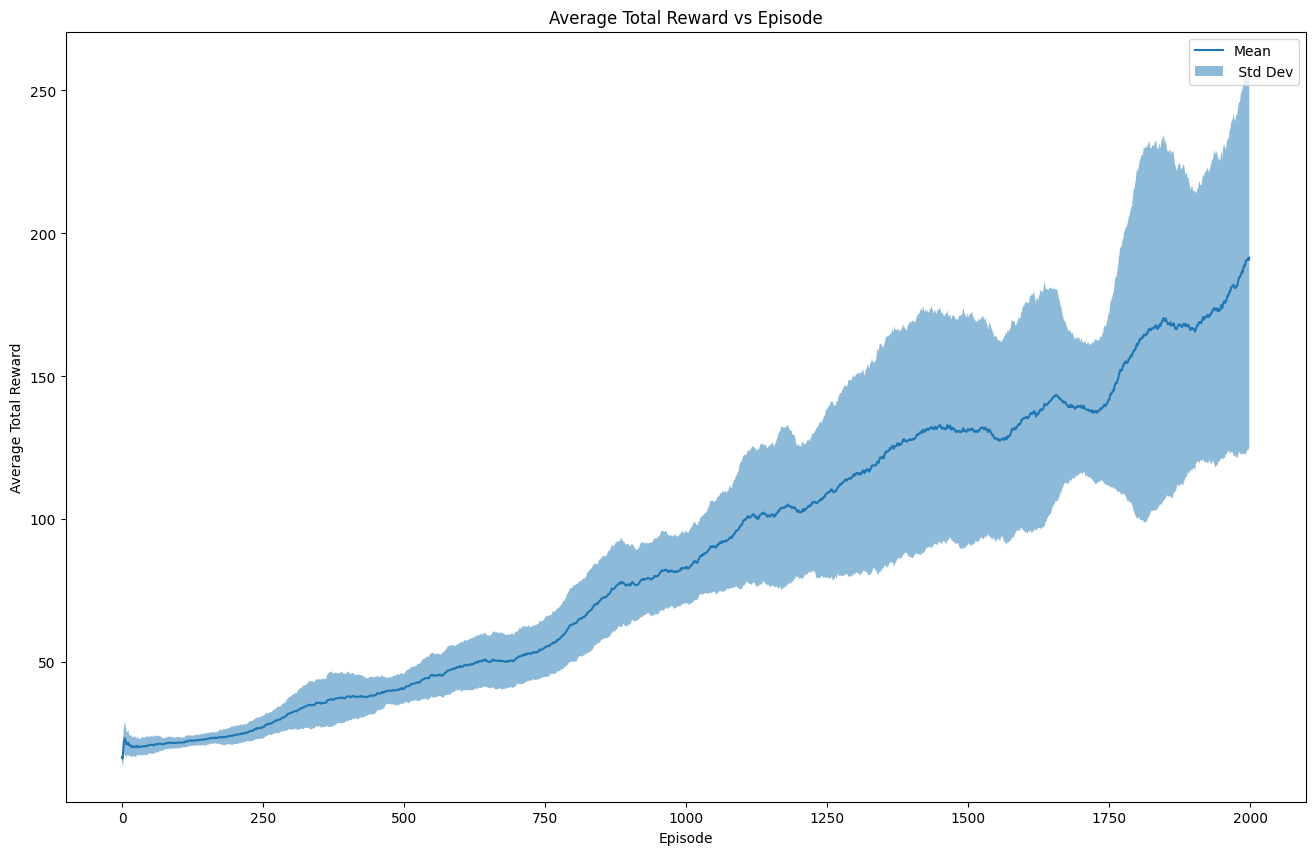

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def plot_avg_curves(avg_reward, step_size=1):
    max_length = max(len(reward) for reward in avg_reward)

    # Initialize arrays to store sum and count of non-zero values for each index
    sum_non_zero = np.zeros(max_length)
    count_non_zero = np.zeros(max_length)

    # Iterate over each list in avg_reward
    for reward in avg_reward:
        for j, value in enumerate(reward):
            if j % step_size == 0:
                sum_non_zero[j] += value
                count_non_zero[j] += 1

    # Calculate mean and standard deviation using non-zero values
    mean_avg_reward = sum_non_zero / count_non_zero
    mean_reward_std = np.zeros(max_length)

    for reward in avg_reward:
        for j, value in enumerate(reward):
            if j % step_size == 0:
                mean_reward_std[j] += (value - mean_avg_reward[j]) ** 2

    mean_reward_std = np.sqrt(mean_reward_std / count_non_zero)

    # Plot the average rewards with mean and standard deviation
    plt.figure()
    plt.plot(mean_avg_reward, label='Mean')
    plt.fill_between(range(0, max_length, step_size), mean_avg_reward + mean_reward_std, mean_avg_reward - mean_reward_std, alpha=0.5, label=' Std Dev')
    plt.xlabel('Episode')
    plt.ylabel('Average Total Reward')
    plt.title('Average Total Reward vs Episode')
    plt.legend()
    plt.show()

# Example usage:
# average_scores = [[1, 2, 3], [4, 5, 6, 7], [8, 9]]

plot_avg_curves(np.array(average_scores), step_size=1)
